#### Reference
- https://www.youtube.com/watch?v=Q_MbN-vu_2w&t=10s
- https://www.kaggle.com/competitions/bike-sharing-demand/overview/description
- https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile

-----

### Target
- 자전거의 대여량(count)을 예측하는 문제.

### Approach
- Regression approach로 접근하여 estimation.(not a classification)
- 독립변수: count를 제외한 나머지의 parameter의 변수
- 종속변수: count, 즉 대여횟수의 변수

### Data Fields from kaggle
- datetime - hourly date + timestamp  
- season
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as
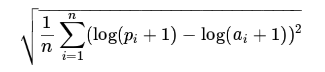

## 1. 필요 라이브러리 import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---------

## 2. Collecting the data
### train 데이터의 분석 using pandas

In [3]:
df_train = pd.read_csv('./data/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('./data/test.csv')

## 아래처럼 datetime 으로 parameter 이름을 넘겨도 가능.
## df_train = pd.read_csv('./data/train.csv', parse_dates=['datetime'])

---

### The sequence of analaysis

- Part1: Exploratory Data Analysis(EDA):
    - 1) Analysis of the features.
    - 2) Finding any relations or trends considering multiple features.


- Part2: Feature Engineering and Data Cleaning:
    - 1) Adding any few features.
    - 2) Removing redundant features.
    - 3) Converting features into suitable form for modeling.


- Part3: Predictive Modeling

## 3. Exploratory Data Analaysis(EDA)
- Analysis of the features
- Finding any relations or tread considering multiple features

train dataset에서 앞에 5개만 출력해서 확인해 보자.

In [4]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data Dictionary
- datetime - hourly date + timestamp  
- season
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [5]:
df_train.shape

(10886, 12)

#### Total rows and columns
Training dataset은 10886 rows & 12 columns 으로 구성되어 있다.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### Types of Features
- Categorical Features
    - 범주형 변수는 두 개 이상의 범주가 있는 변수이며 해당 기능의 각 값은 범주별로 분류될 수 있다. 
    - 예를 들어, 성별은 두 개의 범주(남성과 여성)가 있는 범주형 변수이다. 
    - 이러한 변수는 정렬하거나 순서를 정할 수 없다. Nominal 변수라고도 한다.

 **Categorical Features in the dataset: season, holiday, workingday, weather**


- Ordinal Features: An ordinal variable is similar to categorical values, but the difference between them is that we can have relative ordering or sorting between the values. For eg: If we have a feature like Height with values Tall, Medium, Short, then Height is a ordinal variable. Here we can have a relative sort in the variable.

    **Ordinal Features in the dataset: PClass**


- Continous Feature: A feature is said to be continous if it can take values between any two points or between the minimum or maximum values in the features column.

 **Continous Features in the dataset: temp, atemp, humidity, windspeed, casual, registered, count**

### a) Analysing The Features
#### Bar Chart for Categorical Features
- season
- holiday
- workingday
- weather
- temp
- atemp
- humidity
- windspeed
- casual
- registered

ValueError: Could not interpret input 'year'

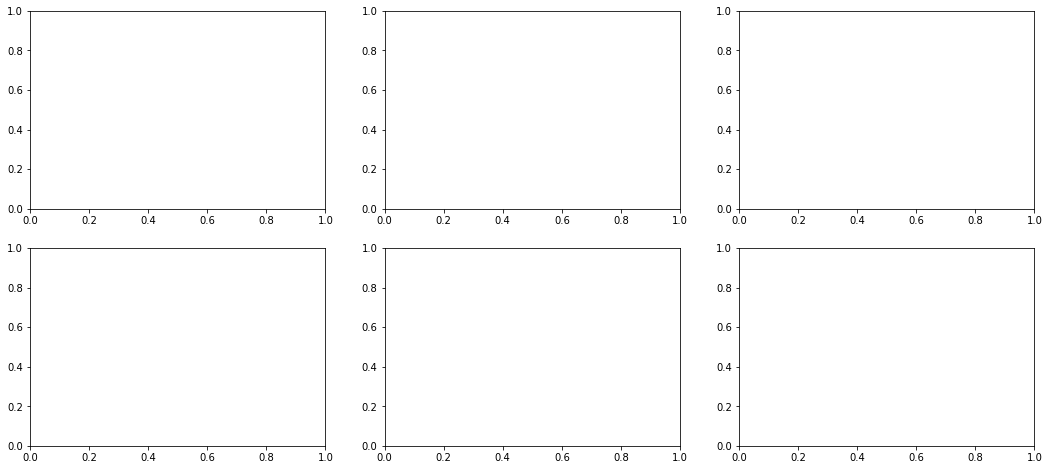

In [8]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=df_train, x="year", y="count", ax=ax1)
sns.barplot(data=df_train, x="month", y="count", ax=ax2)
sns.barplot(data=df_train, x="day", y="count", ax=ax3)
sns.barplot(data=df_train, x="hour", y="count", ax=ax4)
sns.barplot(data=df_train, x="minute", y="count", ax=ax5)
sns.barplot(data=df_train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

### Feature Engineering
- 데이터의 누락이 없어 보이며, 11개의 columns을 가지고 있다.
- datetime 열에서 **새로운 열** [year,	month, day, hour, minute, second]을 생성한다.
    - 이미 유용한 기능을 추출했으므로 datetime 열을 삭제
- 하지만 season, holiday, workingday and weather는 int 타입이 아닌 **categorical** 이어야 한다.

#### a. 기존에 있는 datatime열에서 새로운 열 추출
- 새로운 열 추출 후, datetime drop

In [ ]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train["minute"] = df_train["datetime"].dt.minute
df_train["second"] = df_train["datetime"].dt.second

df_train = df_train.drop(['datetime'], axis=1)

#### b. Category type으로 변환

In [ ]:
categoryVariableList = ['season', 'holiday', 'workingday', 'weather']
for var in categoryVariableList:
    df_train[var] = df_train[var].astype('category')

In [ ]:
df_train.head()

In [ ]:
df_train.info()

### a. Python lib for visualization